In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_path = "/kaggle/input/multi-class-knee-osteoporosis-x-ray-dataset/OS Collected Data" 

images = []
labels = []

for subfolder in os.listdir(data_path):
    
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        labels.append(subfolder)
 
data = pd.DataFrame({'image': images, 'label': labels})

In [3]:
data.head()

,image,label
0,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
1,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
2,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
3,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia
4,/kaggle/input/multi-class-knee-osteoporosis-x-...,Osteopenia


In [4]:
data.shape

(1947, 2)

In [5]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.80, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [6]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (1557, 2)
Validation set shape: (195, 2)
Test set shape: (195, 2)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  
    fill_mode='nearest'
)

ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image',                  
    y_col='label',                 
    target_size=img_size,          
    class_mode='categorical',       
    color_mode='rgb',              
    shuffle=True,                  
    batch_size=batch_size           
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,                  
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,                 
    batch_size=batch_size
)


Found 1557 validated image filenames belonging to 3 classes.
Found 195 validated image filenames belonging to 3 classes.
Found 195 validated image filenames belonging to 3 classes.


In [8]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'Normal': 0, 'Osteopenia': 1, 'Osteoporosis': 2}
{'Normal': 0, 'Osteopenia': 1, 'Osteoporosis': 2}
{'Normal': 0, 'Osteopenia': 1, 'Osteoporosis': 2}


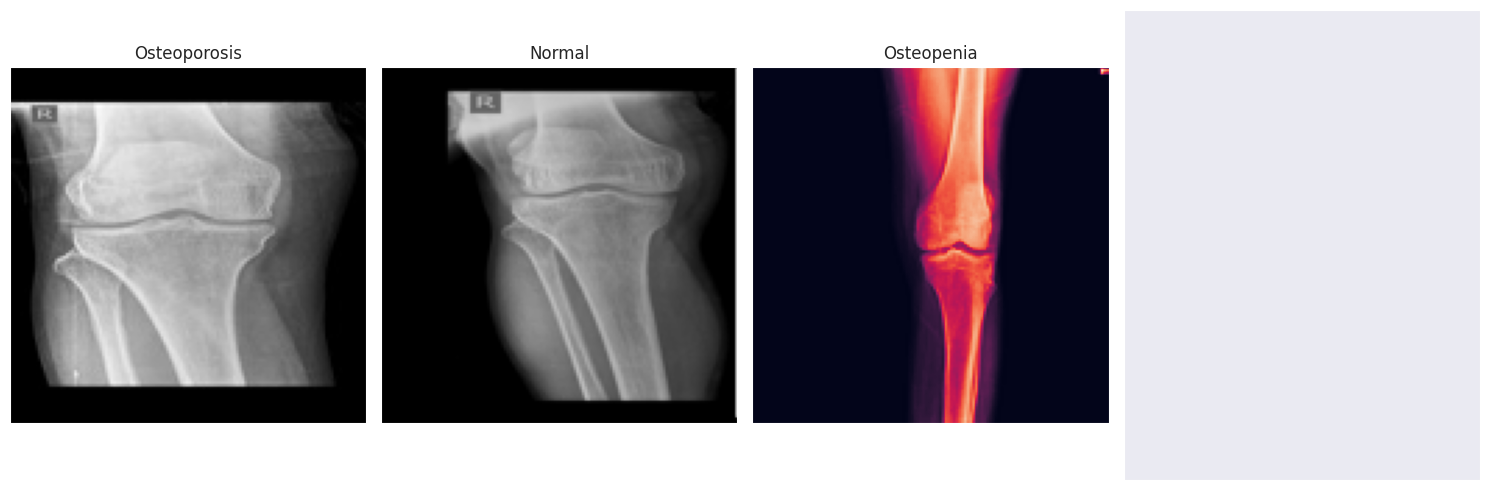

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

class_samples = []

for label in test_df['label'].unique():
    sample = test_df[test_df['label'] == label].iloc[0]  
    class_samples.append((sample['image'], sample['label']))

target_size = (128, 128)  

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for ax, (filepath, label) in zip(axes, class_samples):
    img = Image.open(filepath)
    img_resized = img.resize(target_size)
    ax.imshow(img_resized)
    ax.set_title(label)

plt.tight_layout()
plt.savefig('Display_images.jpg', dpi=1200)
plt.show()


In [11]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if accuracy:
            print(f"Epoch {epoch + 1}: Training accuracy is {accuracy:.4f}")
        if val_accuracy:
            print(f"Epoch {epoch + 1}: Validation accuracy is {val_accuracy:.4f}")
        
        if (accuracy and accuracy > 0.99) or (val_accuracy and val_accuracy > 0.99):
            print("\nReached 99% accuracy in training or validation, so cancelling training!")

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.regularizers import l2

model = Sequential()

model.add(InputLayer(input_shape=(150, 150, 3)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', kernel_regularizer=l2(0.001)))  
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 150, 150, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 618,275 (2.36 MB)

 Trainable params: 616,867 (2.35 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))  

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    LearningRateScheduler(lr_scheduler)
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/10
49/49 - 116s - 2s/step - accuracy: 0.4618 - loss: 1.2136 - val_accuracy: 0.4000 - val_loss: 5.3139 - learning_rate: 0.0010
Epoch 2/10
49/49 - 54s - 1s/step - accuracy: 0.5742 - loss: 1.0637 - val_accuracy: 0.4000 - val_loss: 3.2677 - learning_rate: 0.0010
Epoch 3/10
49/49 - 49s - 993ms/step - accuracy: 0.6121 - loss: 0.9999 - val_accuracy: 0.4000 - val_loss: 2.0467 - learning_rate: 0.0010
Epoch 4/10
49/49 - 50s - 1s/step - accuracy: 0.6339 - loss: 0.9607 - val_accuracy: 0.4615 - val_loss: 1.0891 - learning_rate: 0.0010
Epoch 5/10
49/49 - 55s - 1s/step - accuracy: 0.6384 - loss: 0.9426 - val_accuracy: 0.6462 - val_loss: 0.9711 - learning_rate: 0.0010
Epoch 6/10
49/49 - 49s - 991ms/step - accuracy: 0.6365 - loss: 0.9136 - val_accuracy: 0.3795 - val_loss: 1.6840 - learning_rate: 0.0010
Epoch 7/10
49/49 - 46s - 945ms/step - accuracy: 0.6493 - loss: 0.8880 - val_accuracy: 0.6615 - val_loss: 0.8720 - learning_rate: 0.0010
Epoch 8/10
49/49 - 55s - 1s/step - accuracy: 0.6500 - loss:

In [19]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 586ms/step - accuracy: 0.6714 - loss: 0.8685
Accuracy score: 0.6615384817123413


In [20]:
test_loss, test_accuracy = model.evaluate(test_gen)

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6862 - loss: 0.8282
Test accuracy: 0.6769
Test loss: 0.8766


In [21]:
classes = list(test_gen.class_indices.keys())

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

from sklearn.metrics import classification_report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 736ms/step
              precision    recall  f1-score   support

      Normal       0.92      0.58      0.71        78
  Osteopenia       0.78      0.37      0.50        38
Osteoporosis       0.57      0.92      0.71        79

    accuracy                           0.68       195
   macro avg       0.76      0.62      0.64       195
weighted avg       0.75      0.68      0.67       195



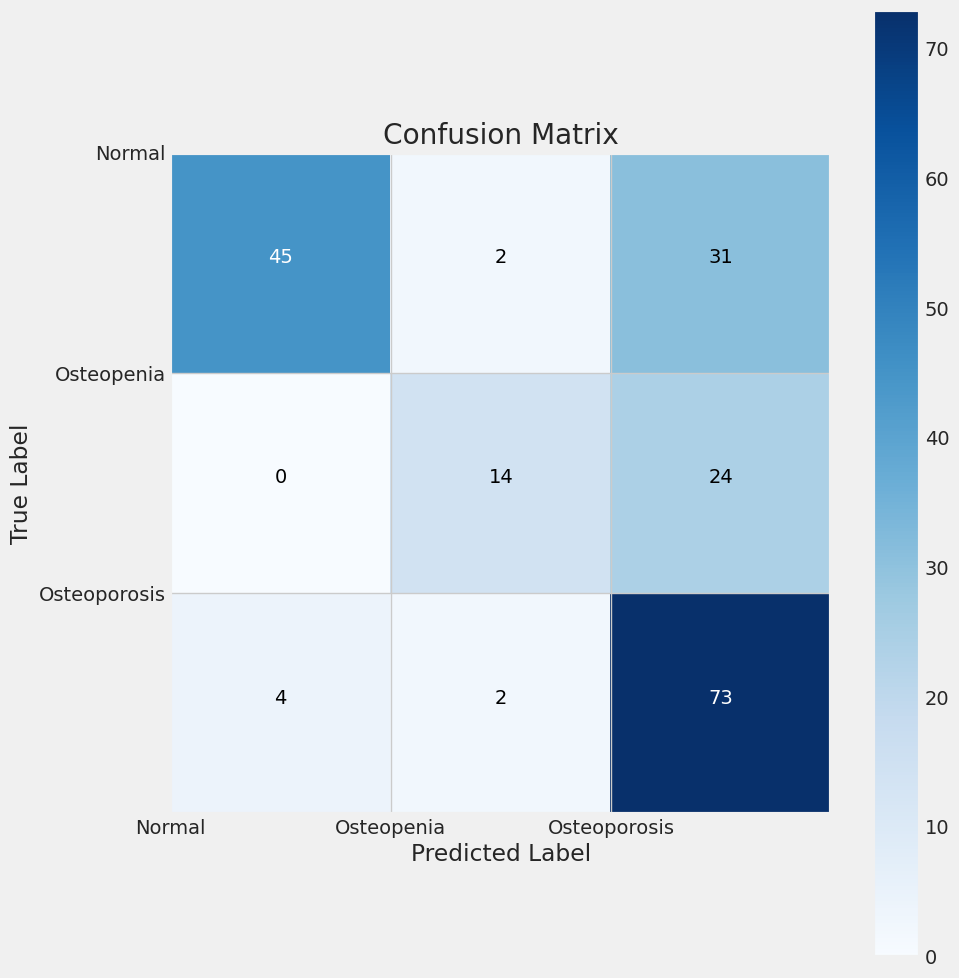

In [22]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.savefig('confusion_matrix.png')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 684ms/step


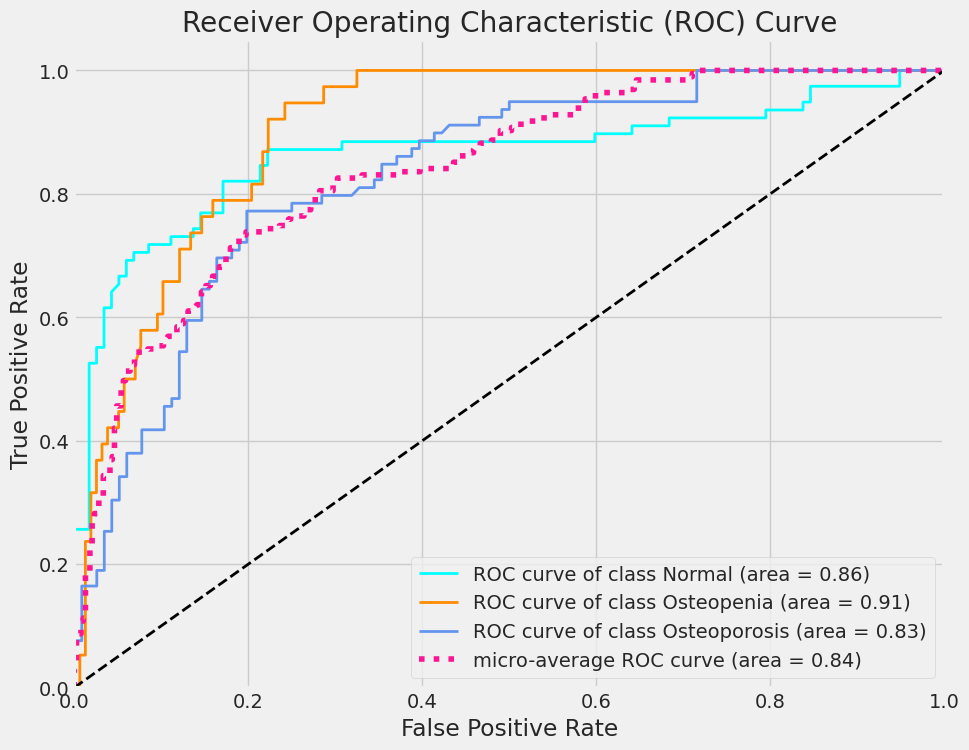

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model.predict(test_gen)  

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.savefig('roc_curve1.png',  dpi=1200) 
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class Normal: 0.86
AUC for class Osteopenia: 0.91
AUC for class Osteoporosis: 0.83
Micro-average AUC: 0.84
Macro-average AUC: 0.87
